# Example 1b: Training of DeepTrack 1.0

Example code to train DeepTrack.

<strong>DeepTrack 1.0</strong><br/>
Digital Video Microscopy enhanced with Deep Learning<br/>
version 1.0 - 30 November 2018<br/>
© Saga Helgadottir, Aykut Argun & Giovanni Volpe<br/>
[Soft Matter Lab](http://www.softmatterlab.org)

## 1. INITIALIZATION

In [1]:
import deeptrack

## 2. DEFINE AND CHECK IMAGE GENERATION ROUTINE
<a id="sec2"></a>

Here, we simulate images of a variety of single particles. The particle position is chosen randomly from a normal distribution with mean of 0 and standard deviation of 1 pixel. The particle has a radius between 1.5 and 3 pixels, and a point-spread function obtained from Bessel function of the first kind of first or second order with positive or negative intensity. The image background, SNR and gradient intensity are randomly selected from a wide range of values. This results in particle images corresponding to dark or bright spots or rings of different intensities on a brigth or dark background with varying SNR and gradient intensity. This image generator was used to train the pretraiend network saved in the file "DeepTrack - Example 1a - Pretrained network.h5".

Comments:
1. The <strong>image_parameters_function</strong> is a lambda function that determines the kind of particle images for which the deep learning network will be trained. Tuning its parameters is the simplest way to improve the tracking performance.<br/>
2. The <strong>image_generator</strong> is a lambda function that works as image genrator. It does not need to be changed in most cases.<br/>
3. The parameter <strong>number_of_images_to_show</strong> determines the number of sample images that are shown.
4. The <font color=red><strong>red<strong></font> symbol superimposed to the images represents the ground truth particle position.

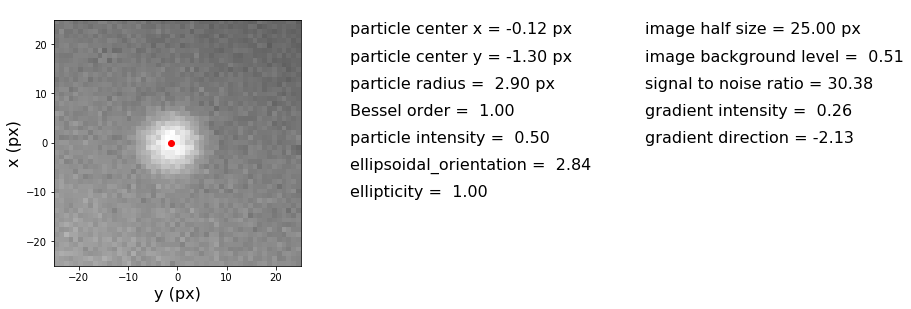

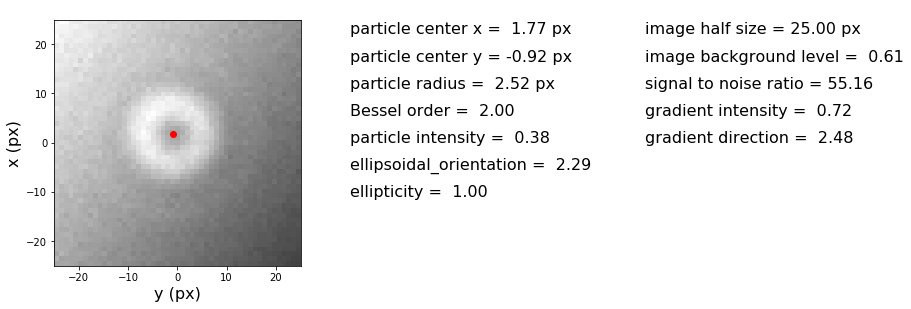

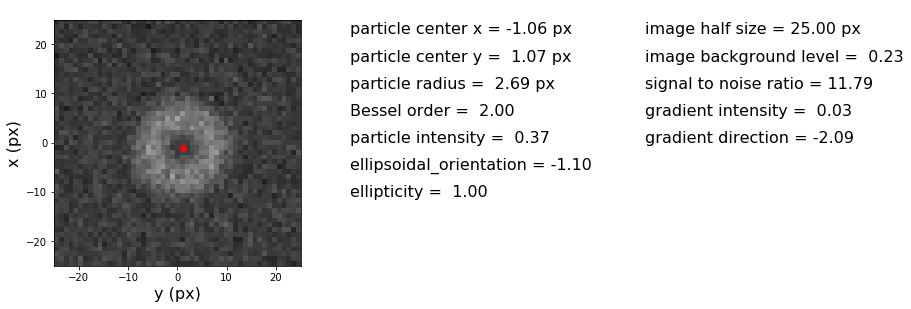

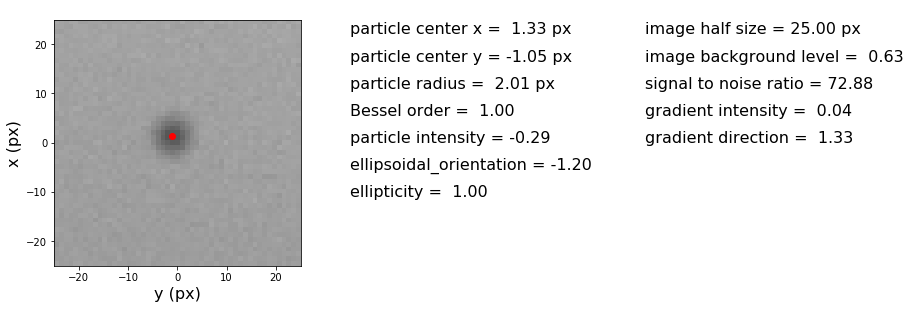

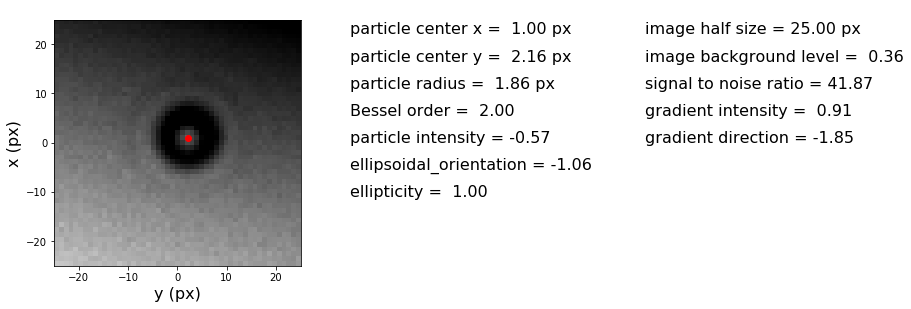

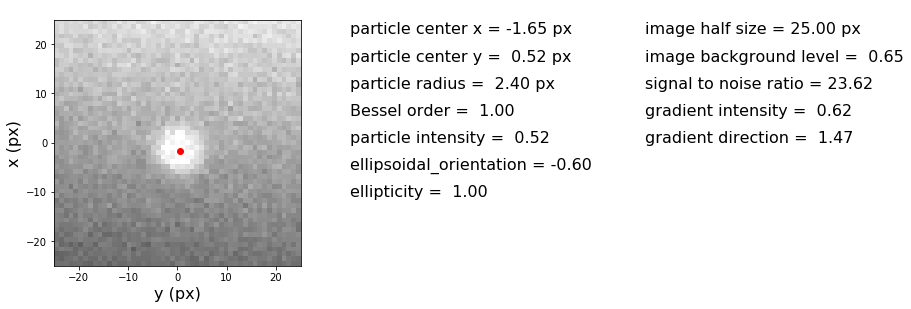

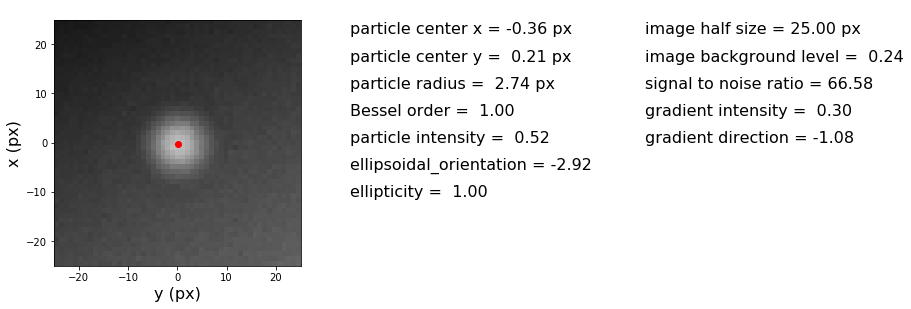

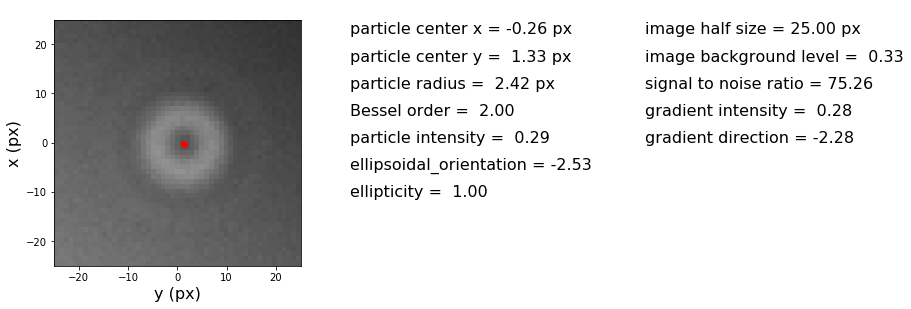

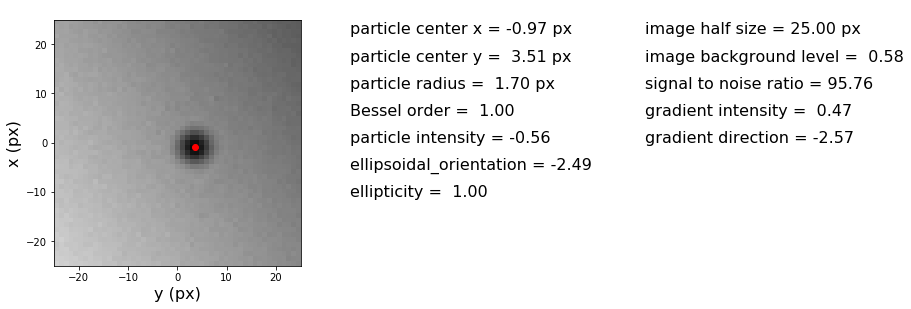

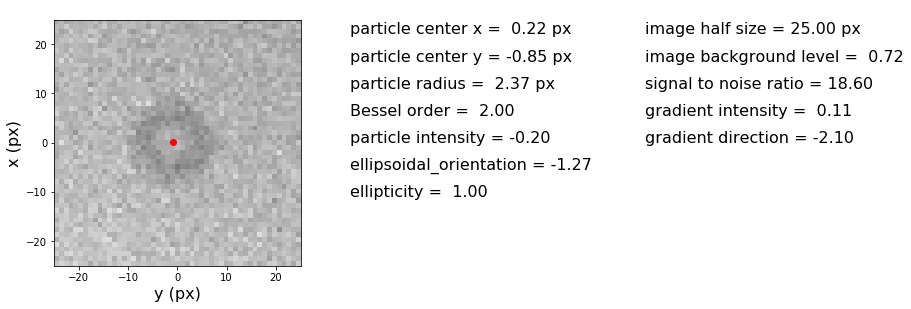

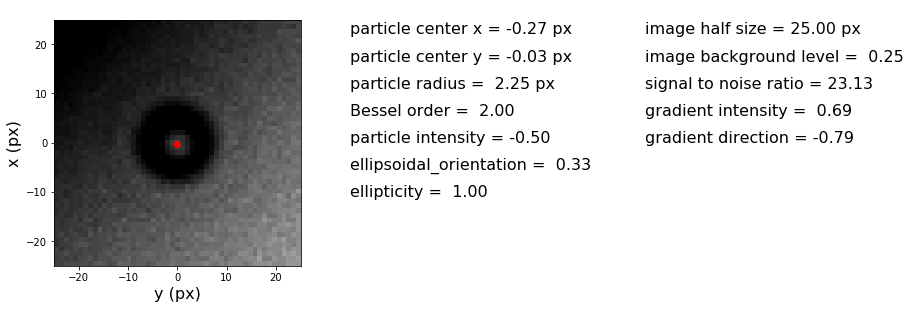

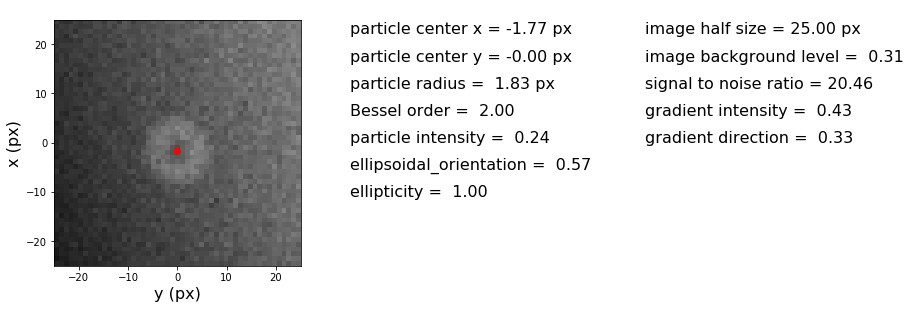

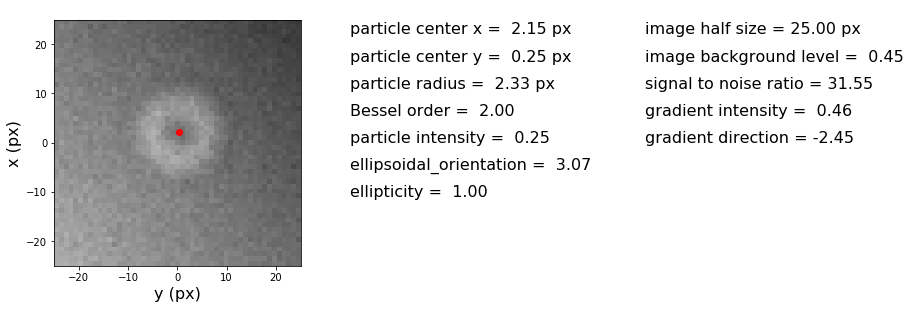

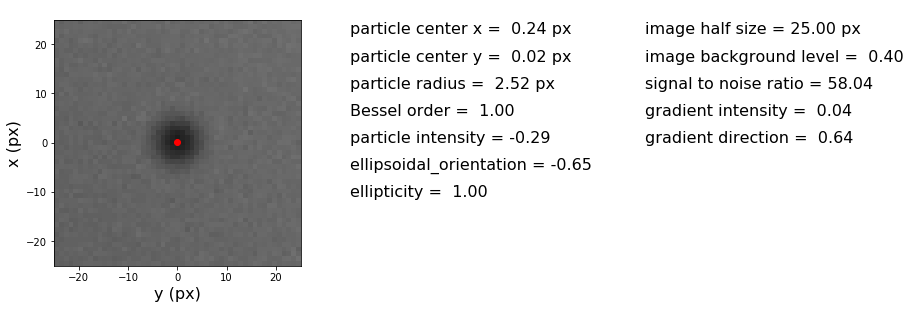

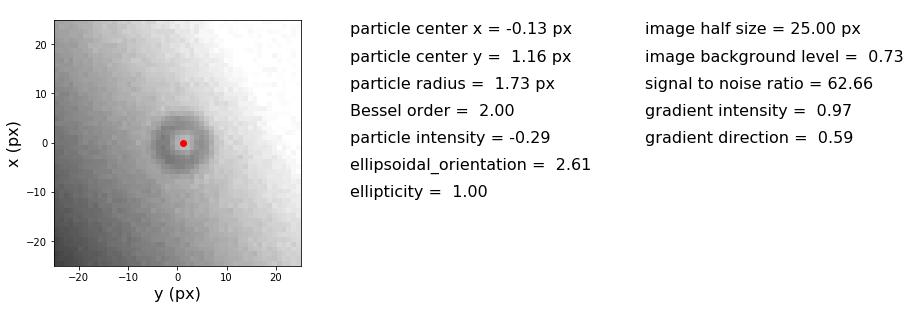

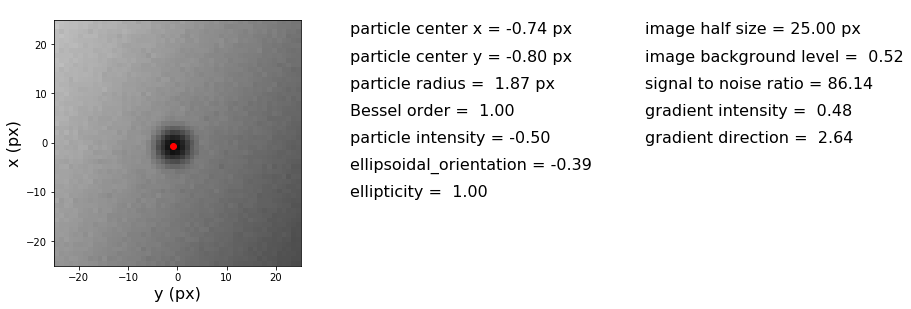

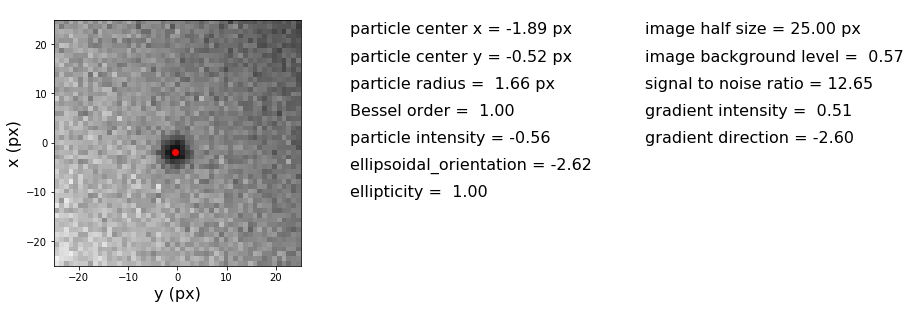

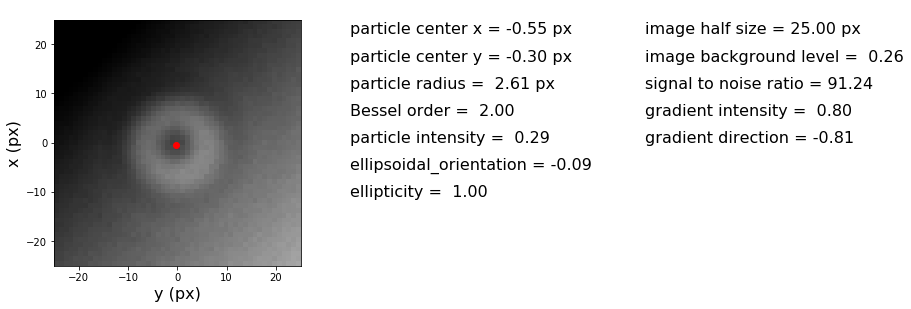

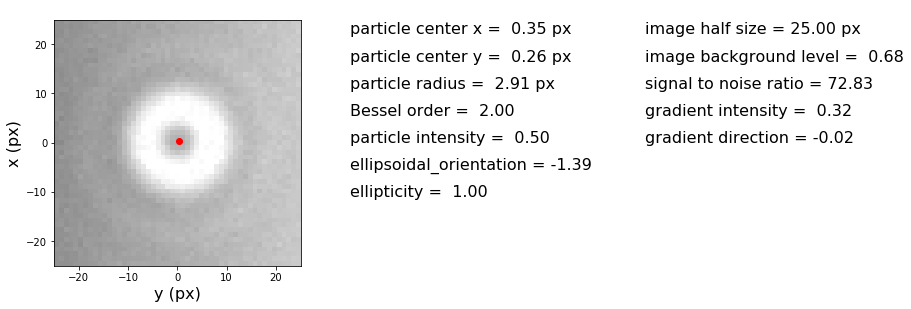

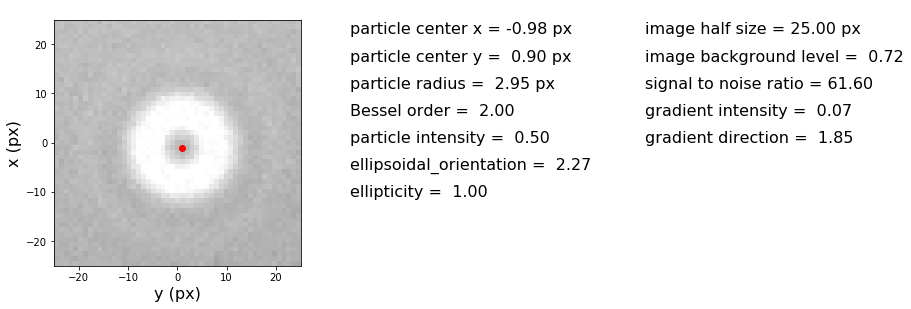

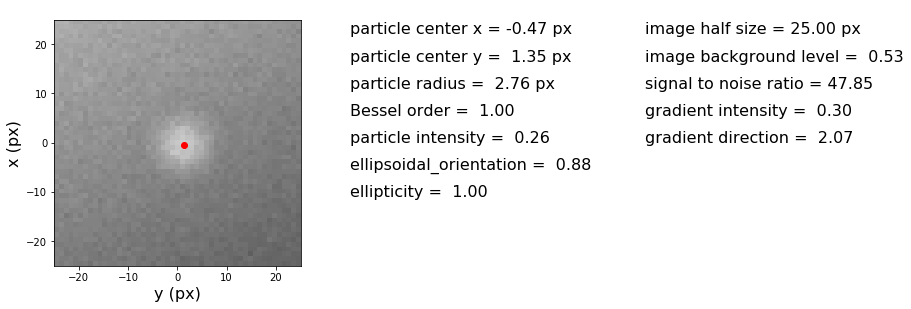

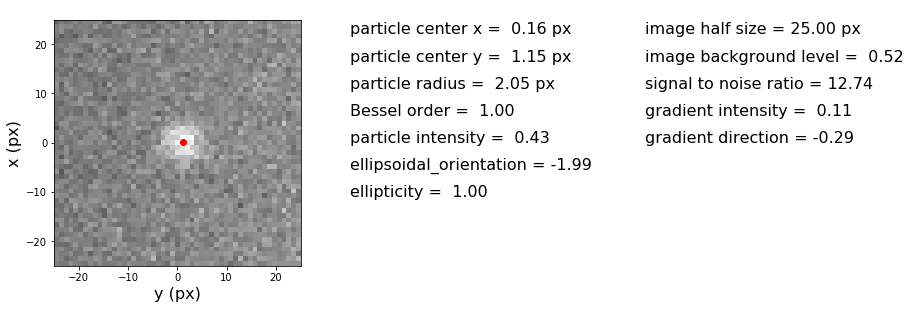

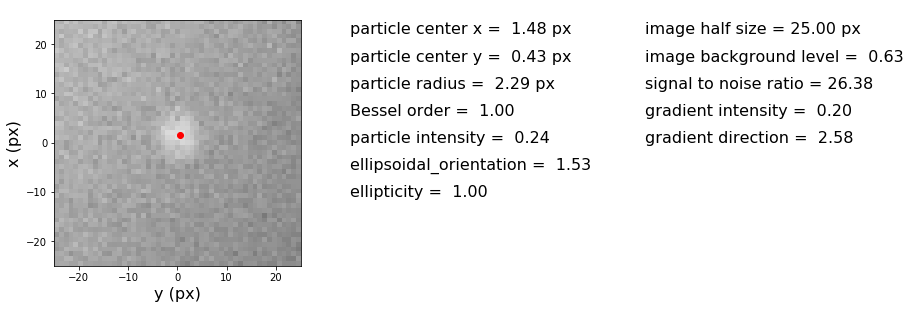

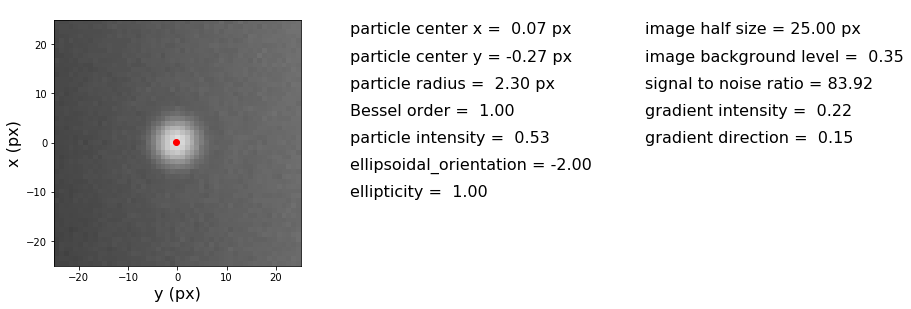

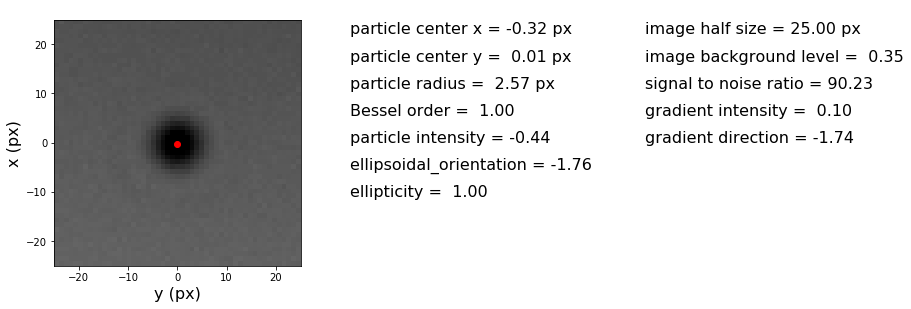

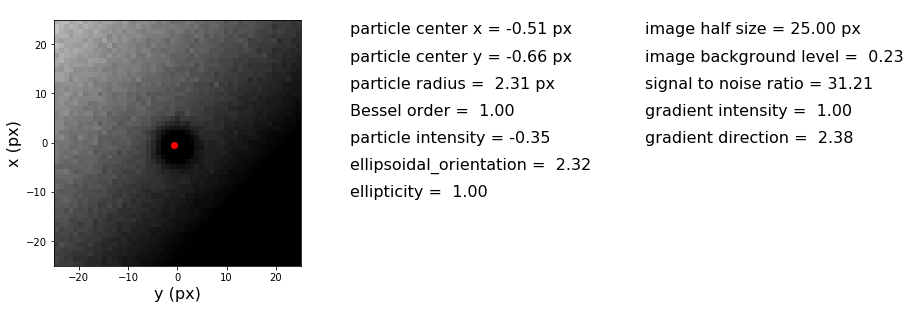

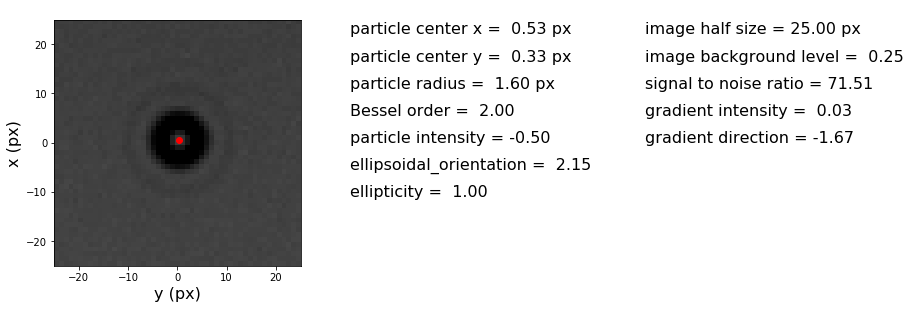

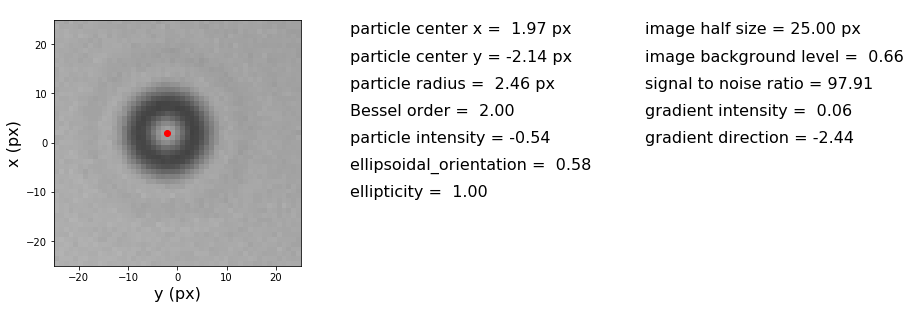

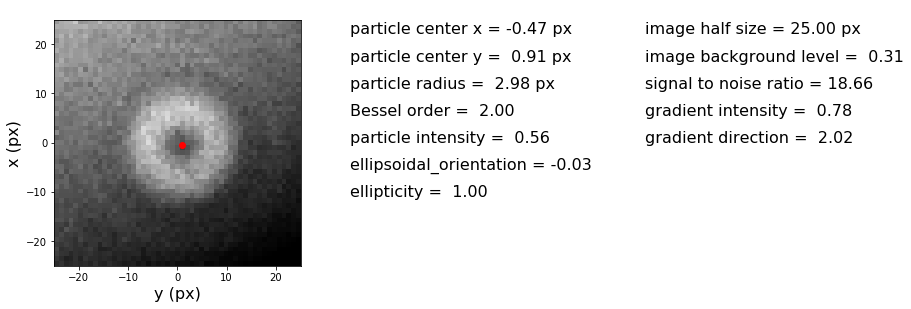

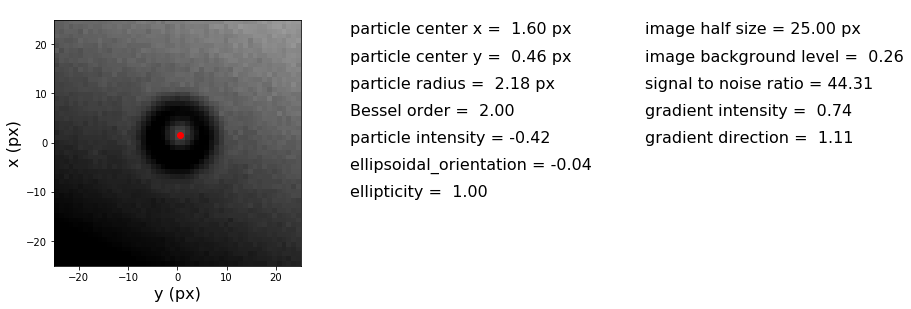

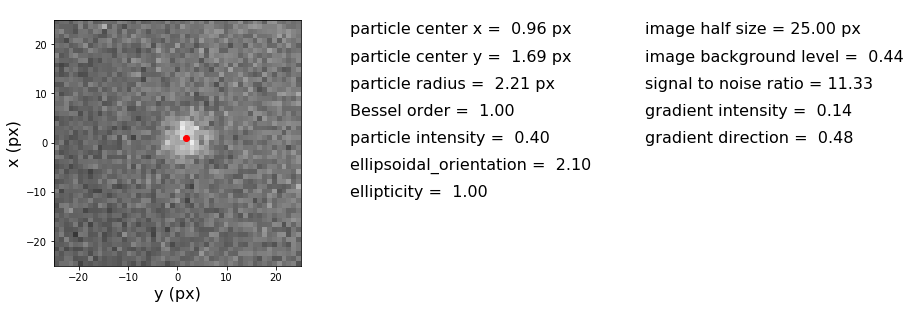

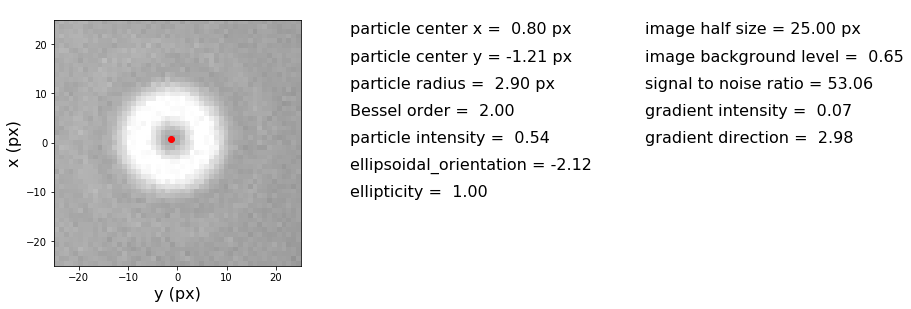

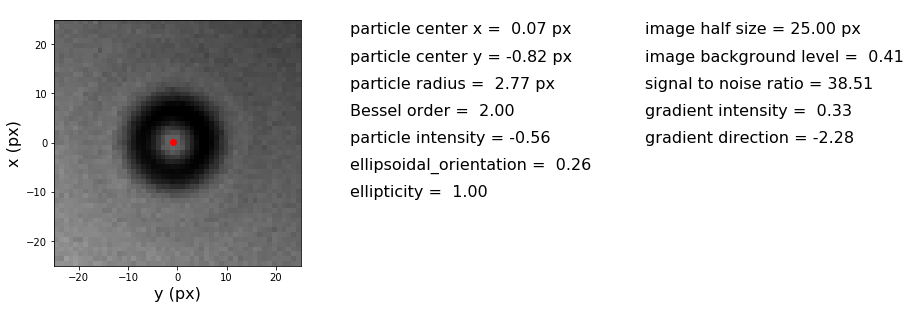

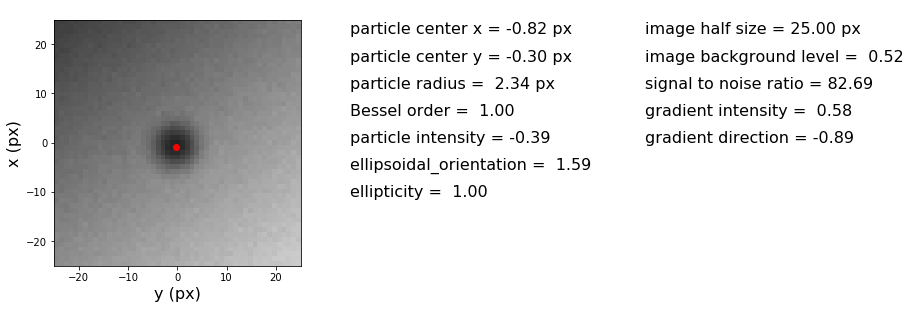

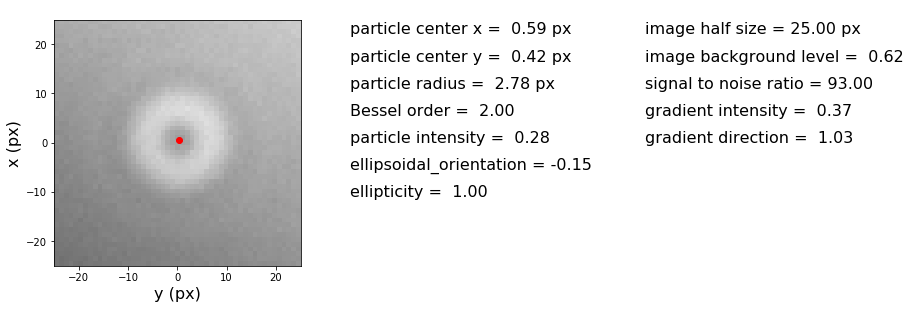

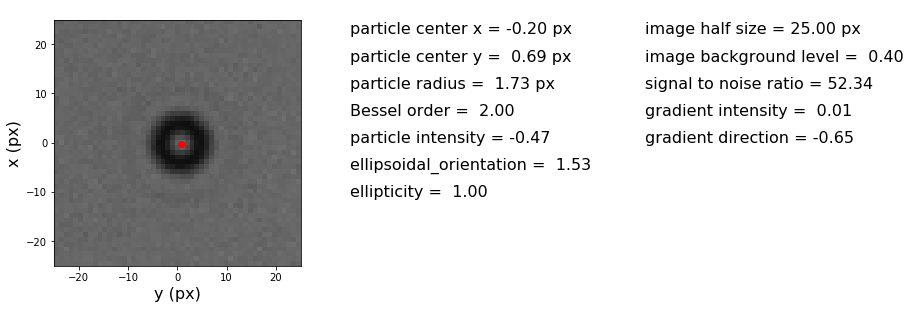

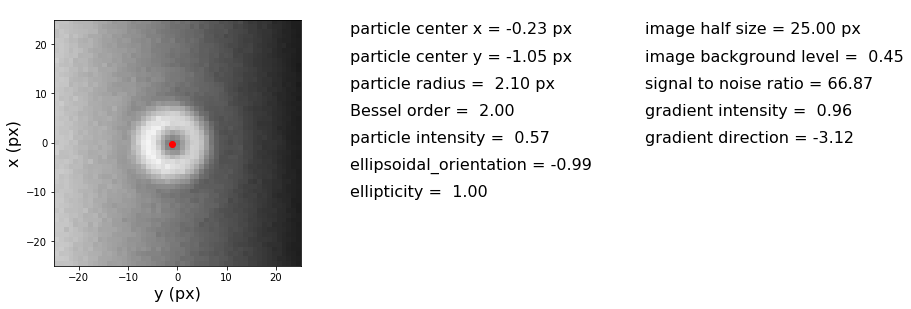

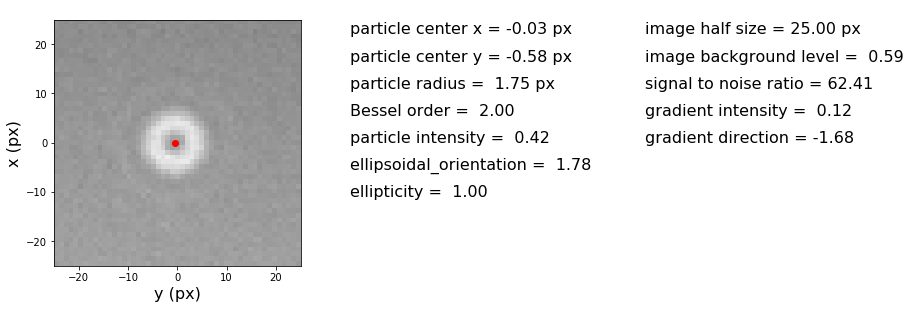

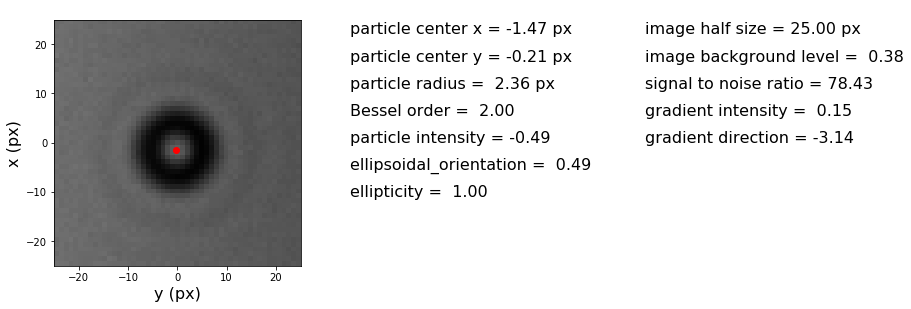

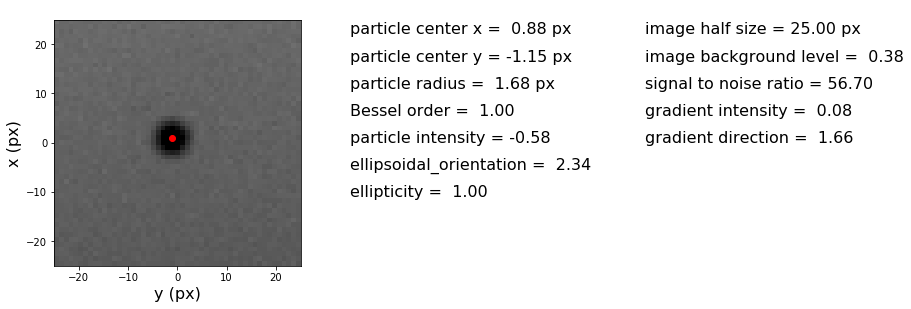

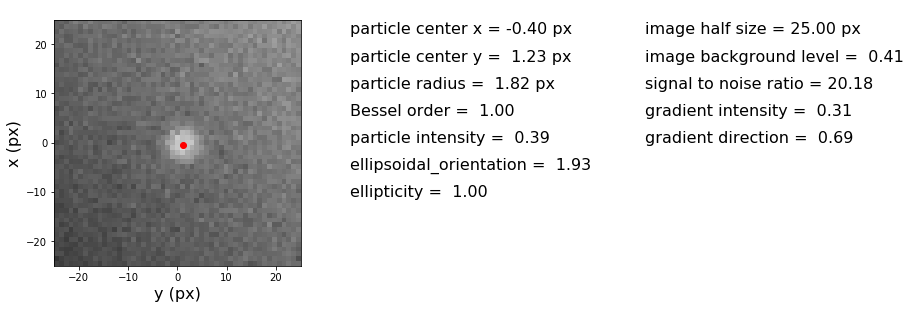

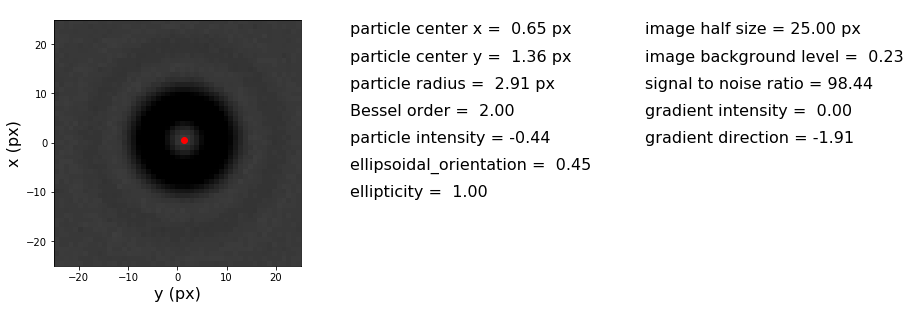

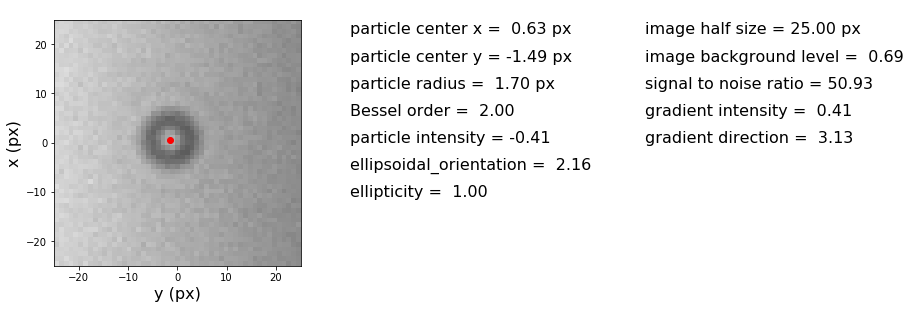

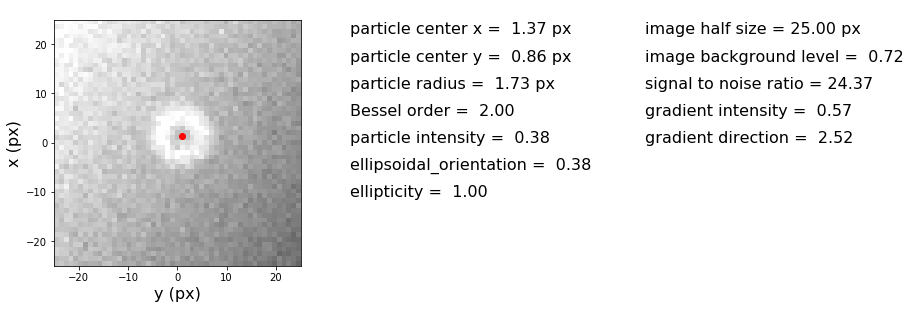

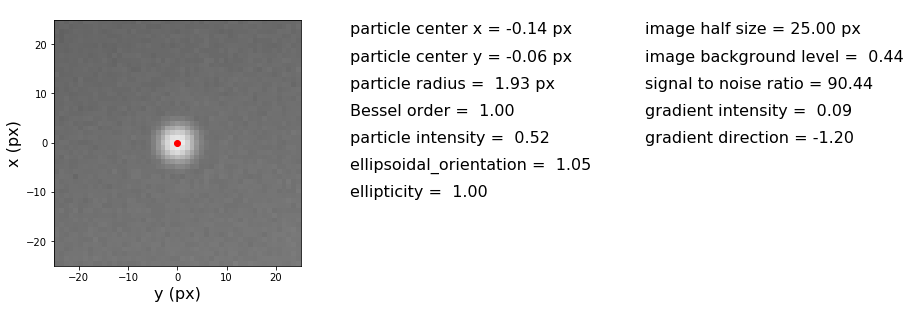

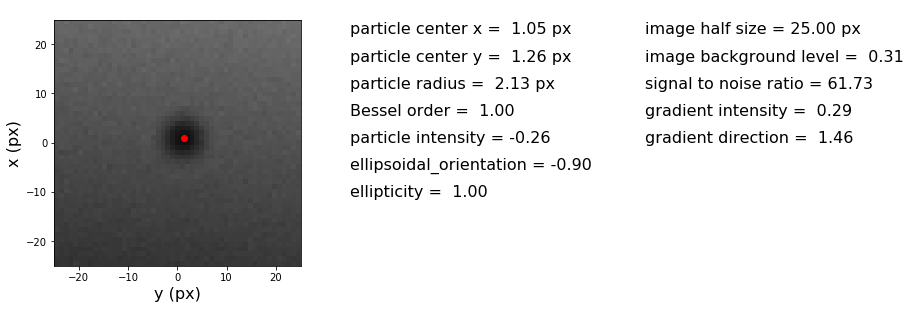

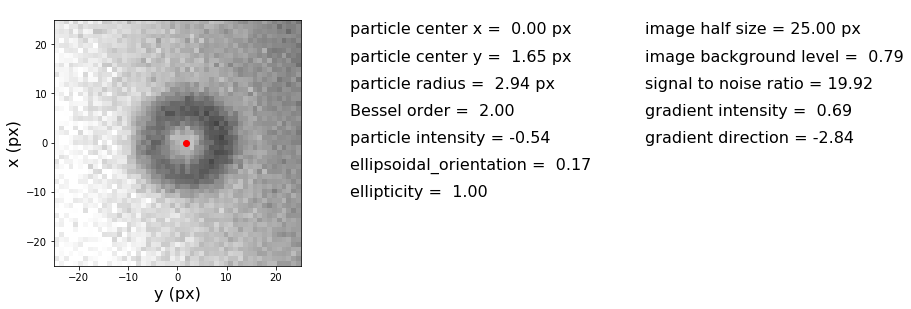

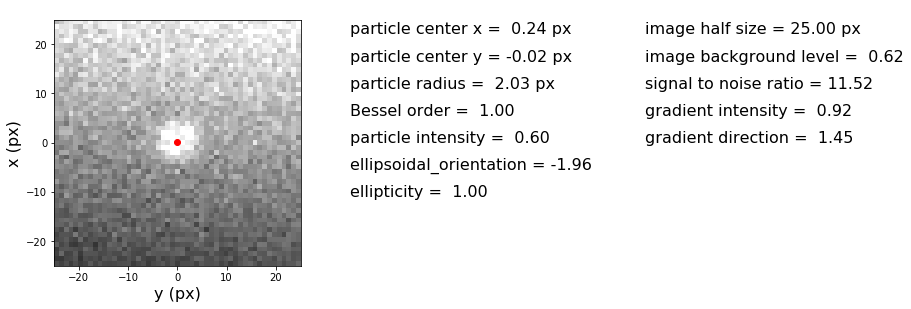

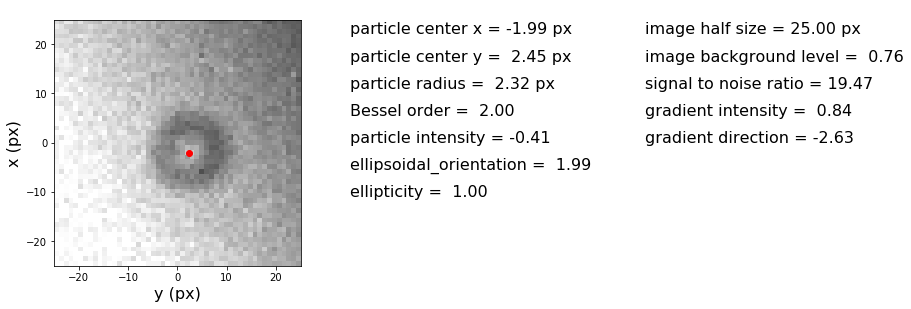

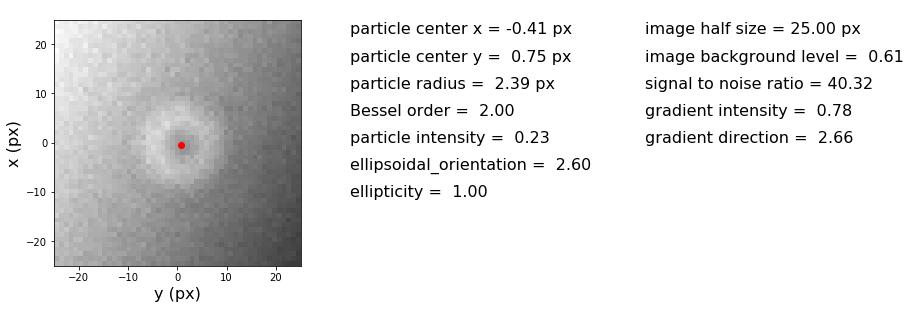

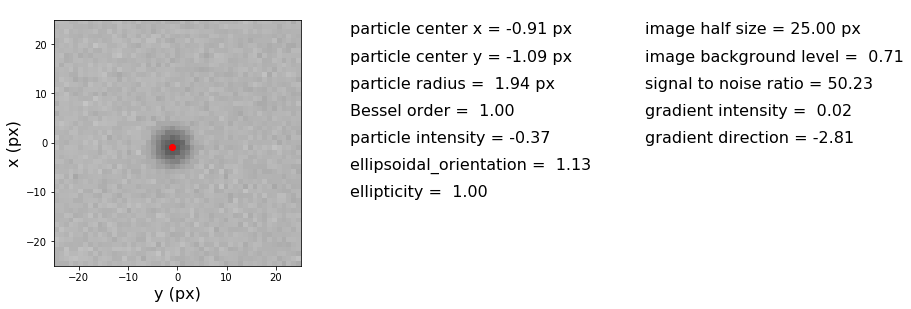

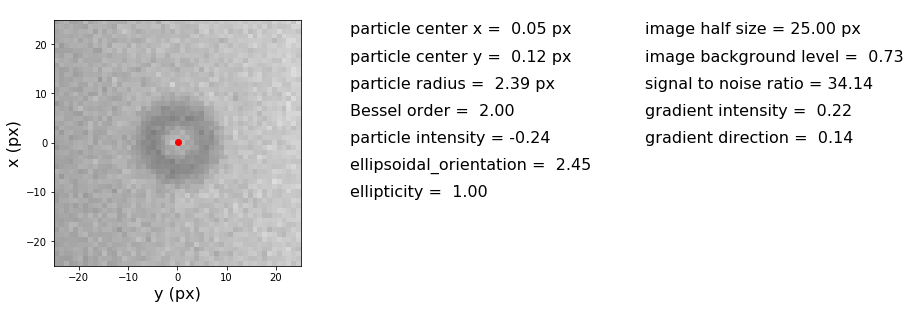

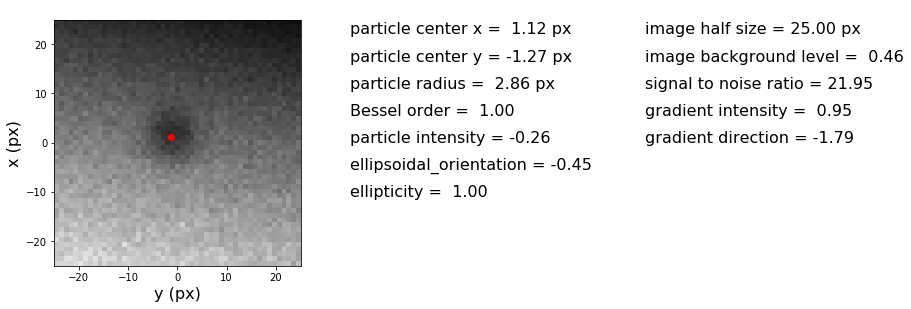

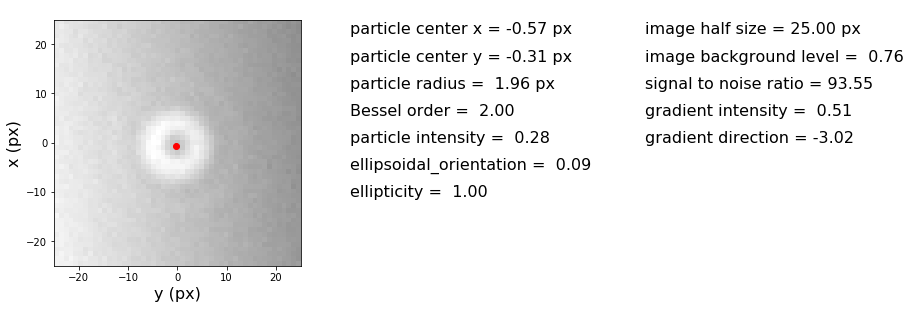

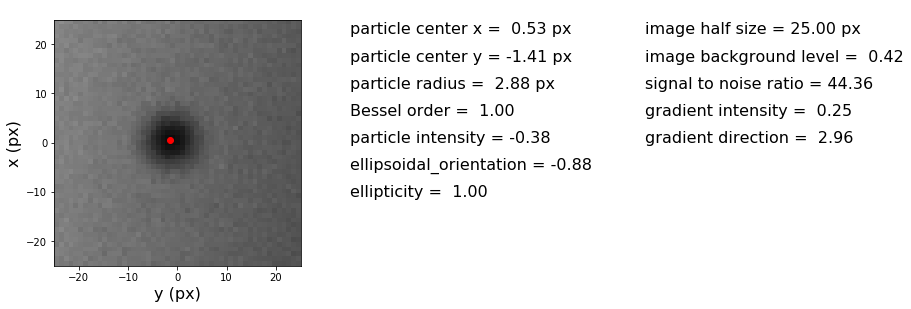

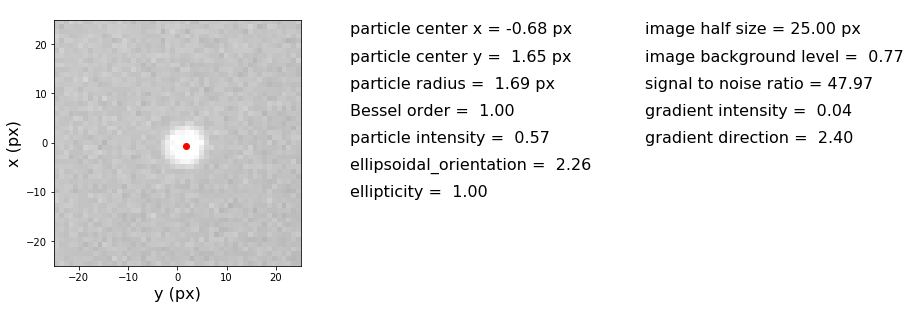

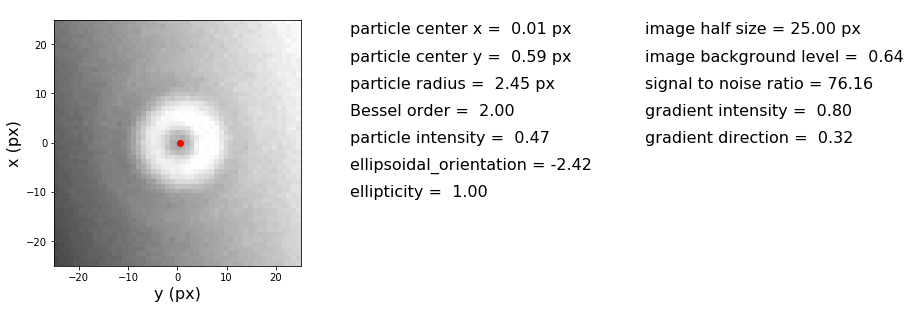

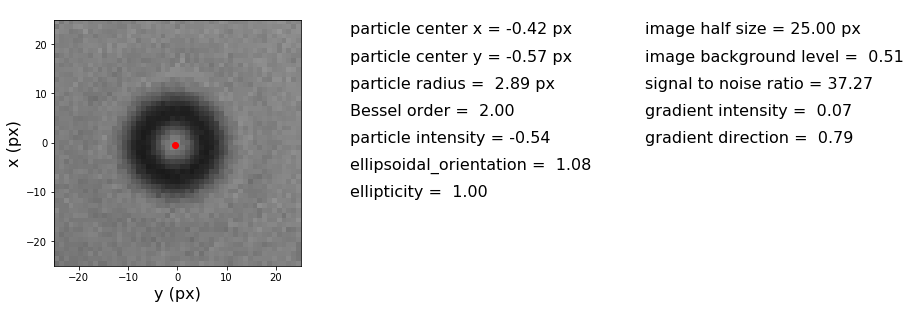

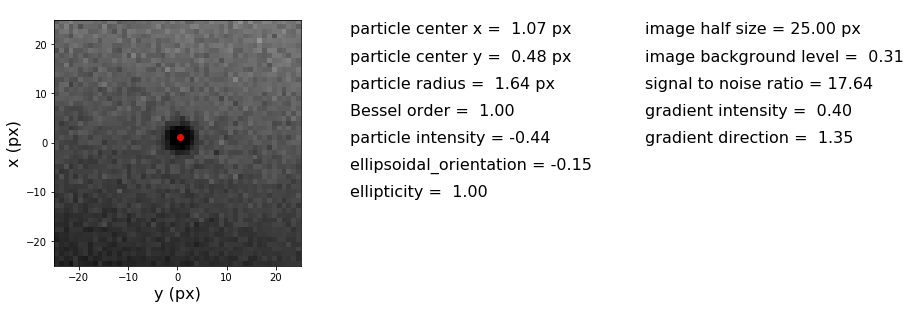

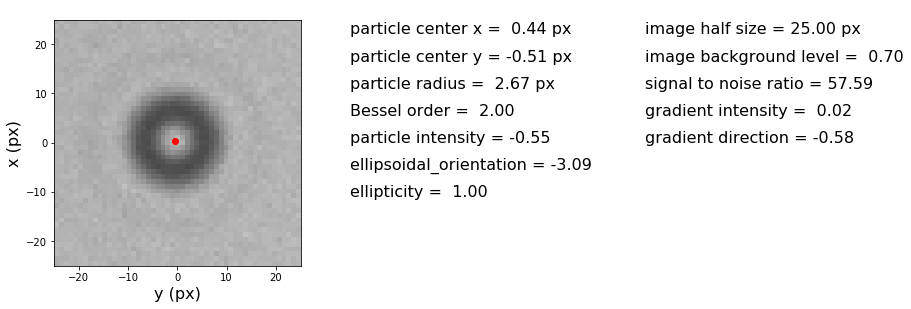

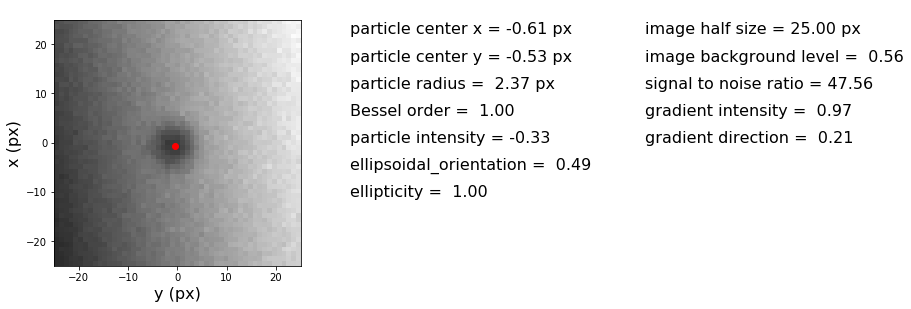

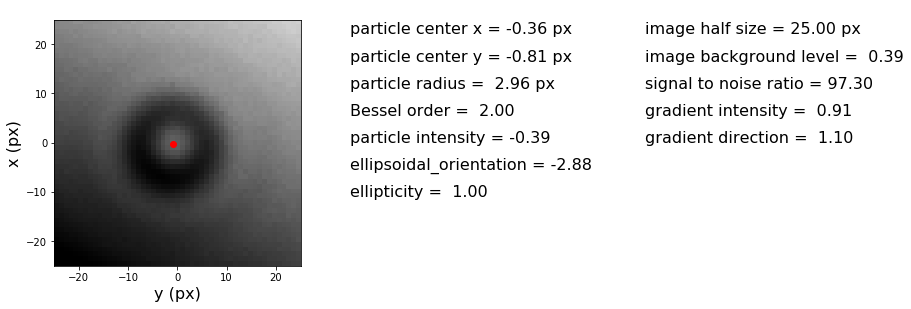

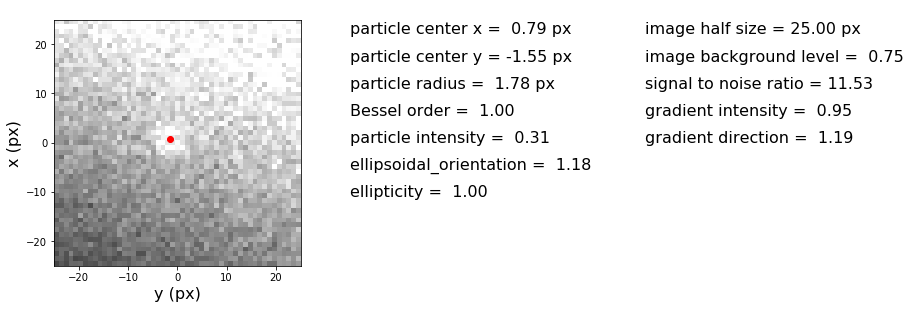

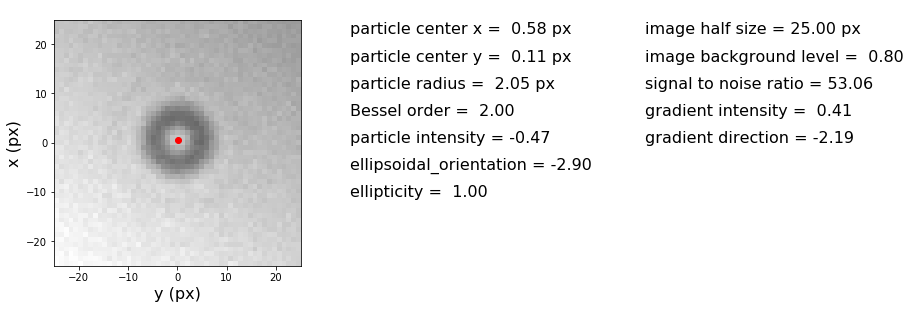

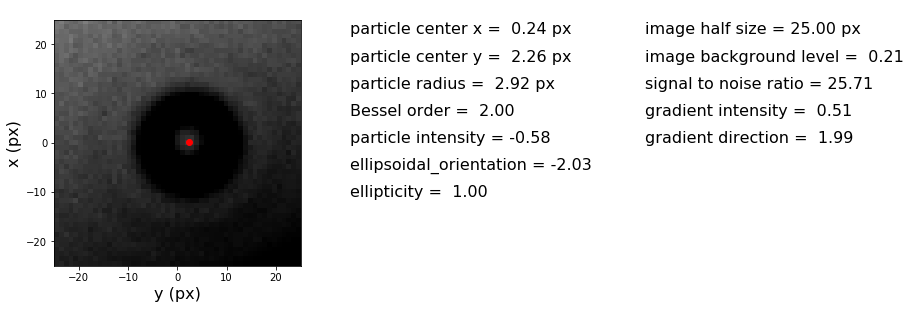

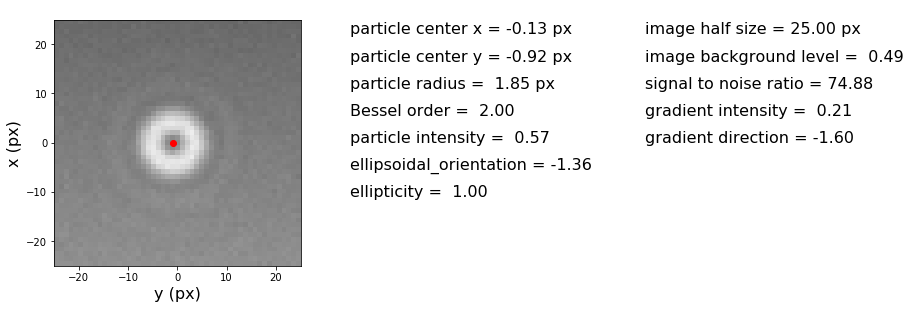

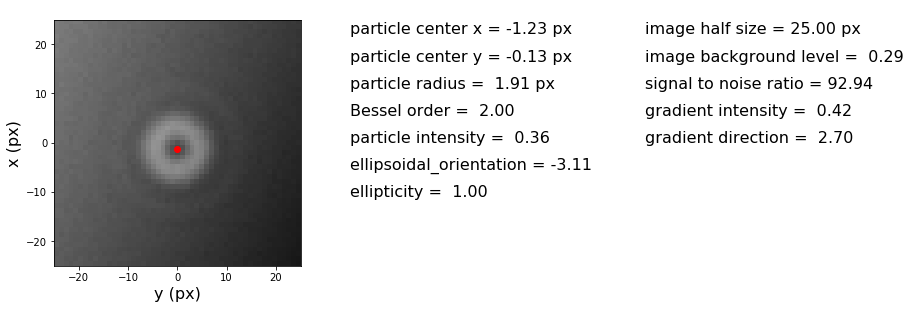

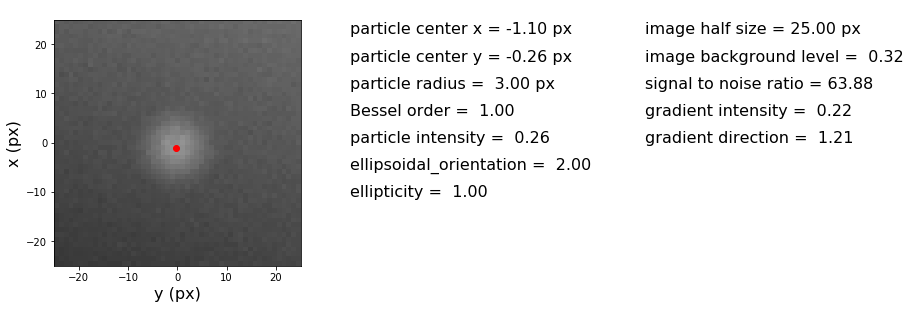

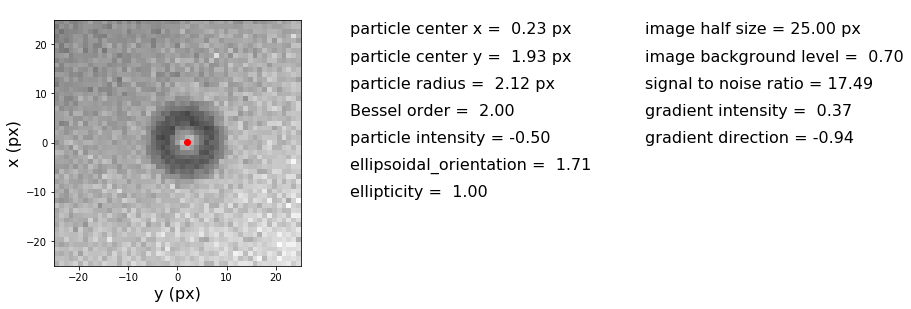

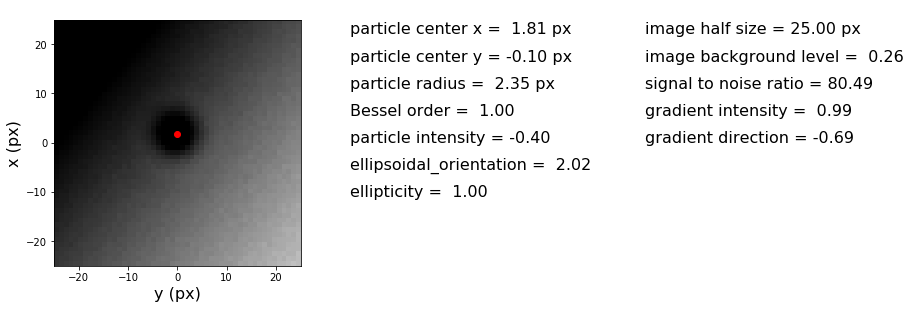

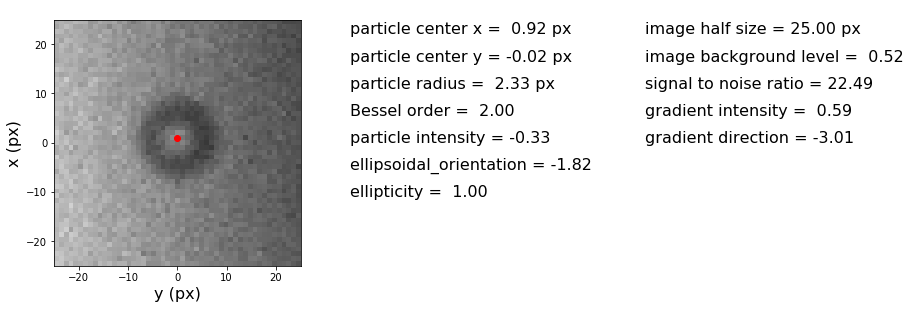

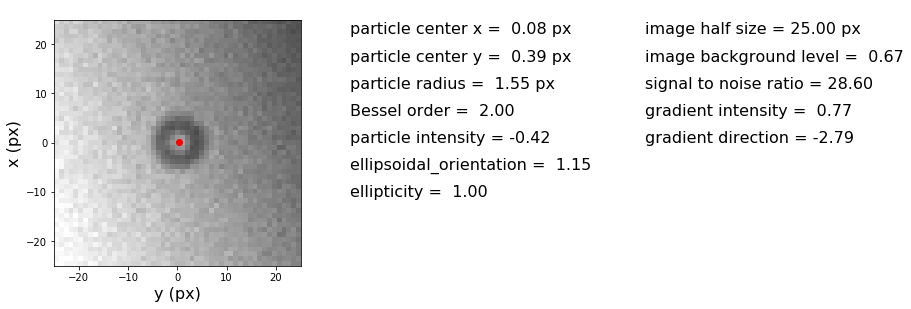

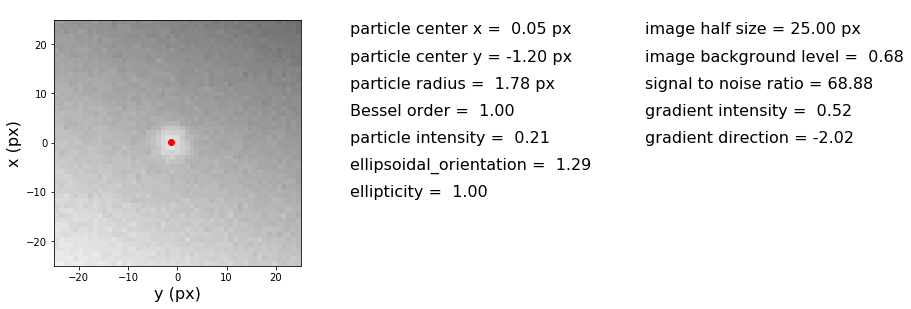

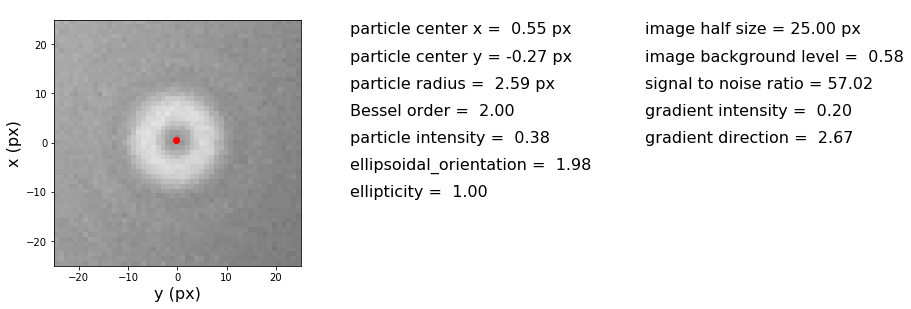

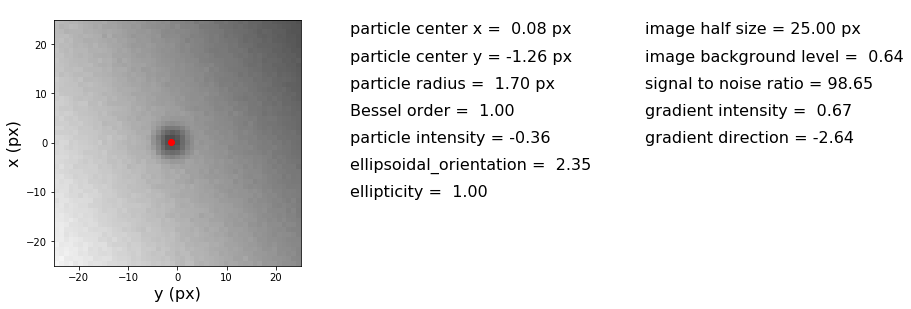

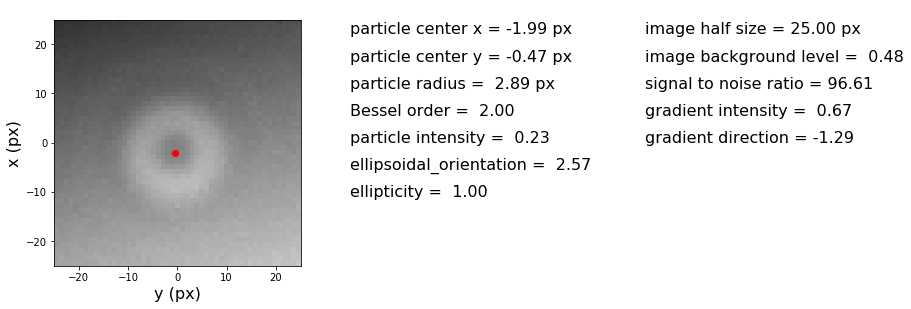

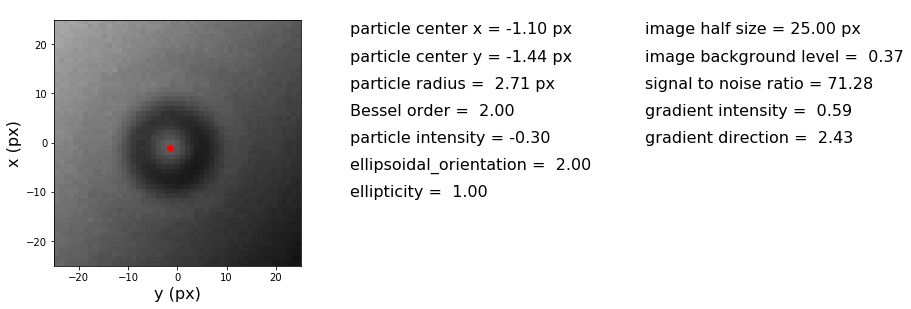

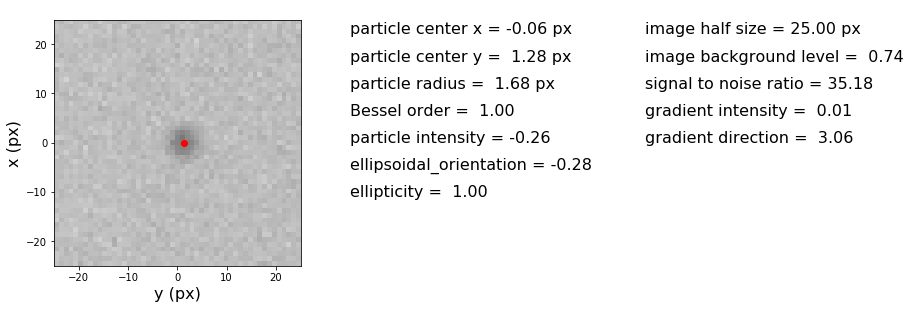

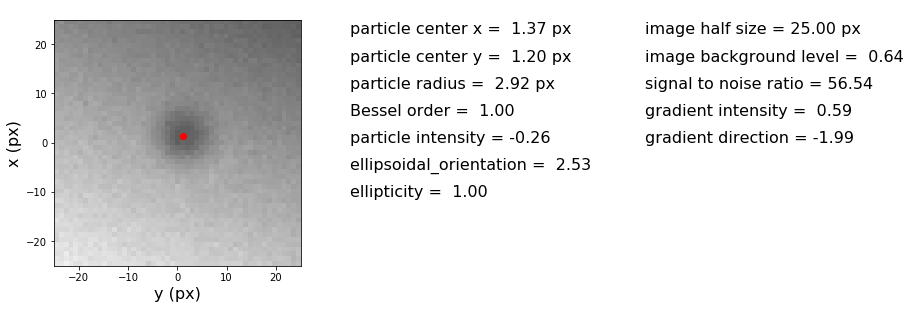

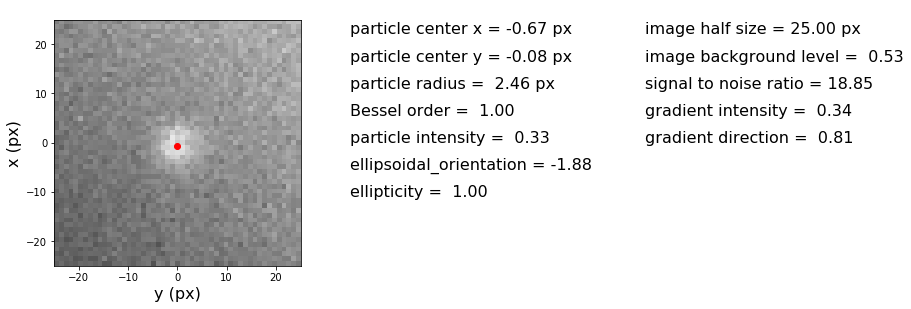

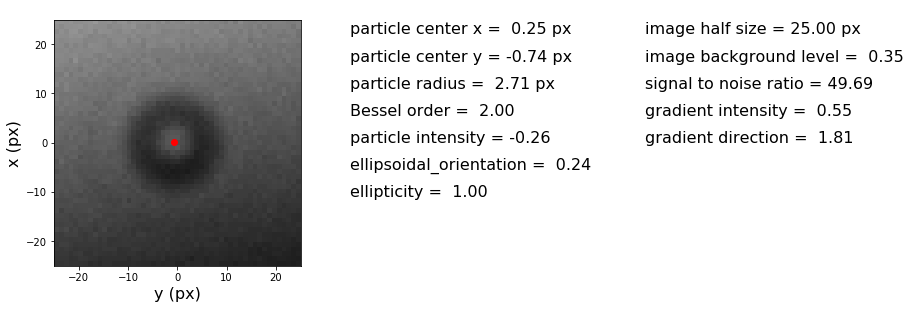

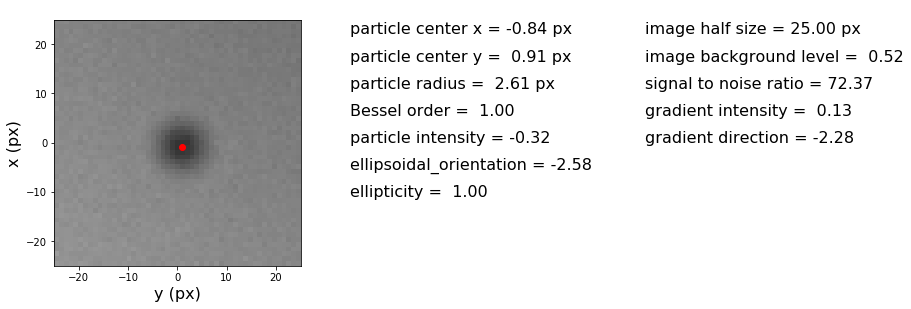

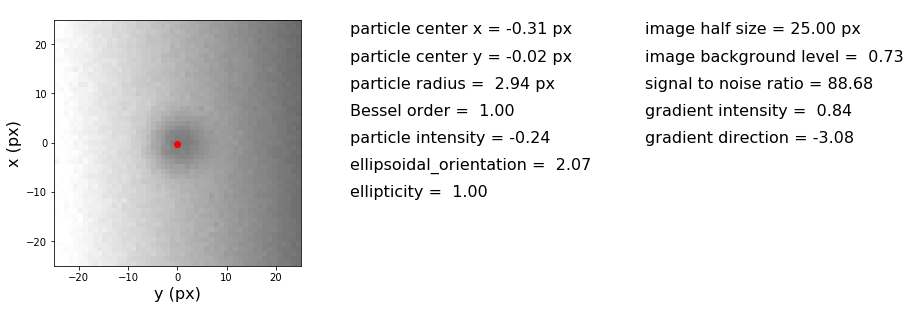

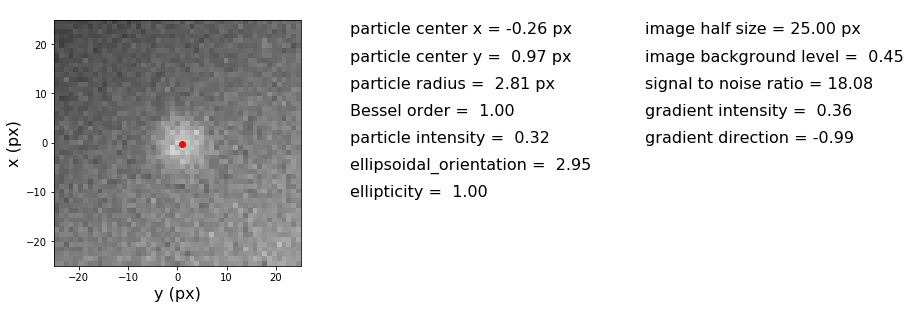

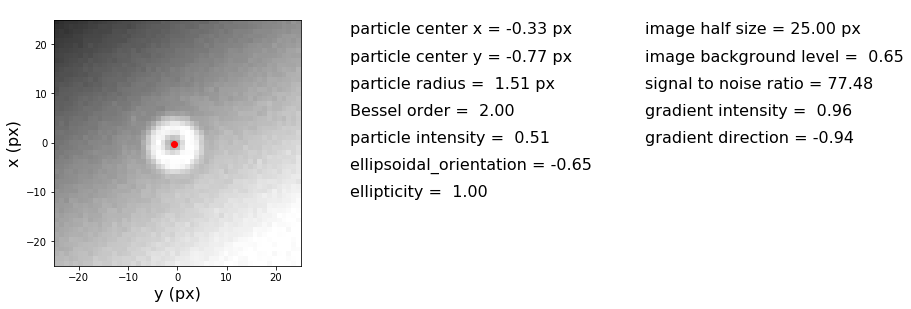

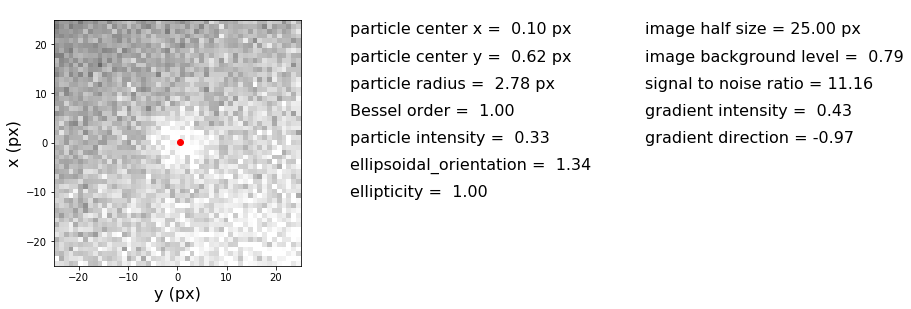

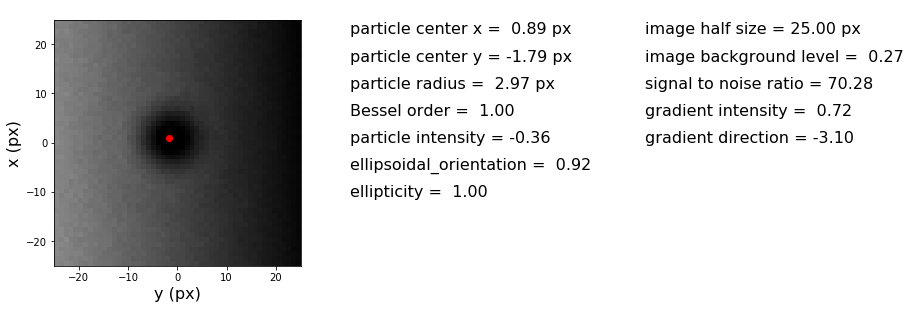

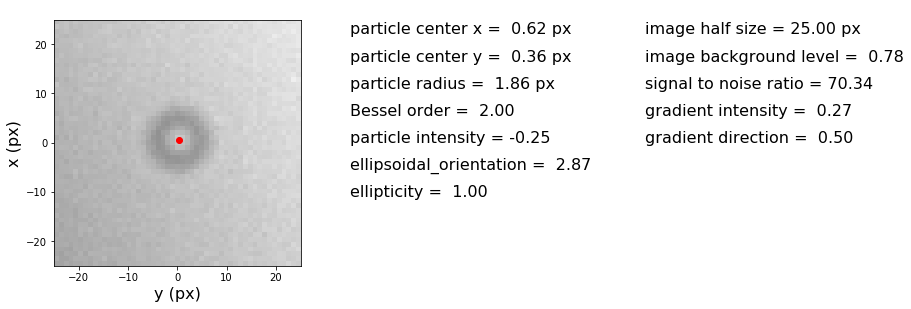

In [2]:
### Define image properties
%matplotlib inline
from numpy.random import randint, uniform, normal, choice
from math import pi

image_parameters_function = lambda : deeptrack.get_image_parameters(
   particle_center_x_list=lambda : normal(0, 1, 1),
   particle_center_y_list=lambda : normal(0, 1, 1),
   particle_radius_list=lambda : uniform(1.5, 3, 1),
   particle_bessel_orders_list=lambda : [[randint(1, 3),], ], 
   particle_intensities_list=lambda : [[choice([-1, 1]) * uniform(.2, .6, 1), ], ],
   image_half_size=lambda : 25, 
   image_background_level=lambda : uniform(.2, .8),
   signal_to_noise_ratio=lambda : uniform(10, 100),
   gradient_intensity=lambda : uniform(0, 1), 
   gradient_direction=lambda : uniform(-pi, pi),
   ellipsoidal_orientation=lambda : uniform(-pi, pi, 1),
   ellipticity=lambda : 1)


### Define image generator
image_generator = lambda : deeptrack.get_image_generator(image_parameters_function)

### Show some examples of generated images
number_of_images_to_show = 100

for image_number, image, image_parameters in image_generator():
    if image_number>=number_of_images_to_show:
        break
    
    deeptrack.plot_sample_image(image, image_parameters)

## 3. CREATE AND COMPILE DEEP LEARNING NETWORK

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.  

Comments:
1. The parameter <strong>input_shape</strong> determines the shape of the input image (x-pixels by y-pixels by color channels).
2. The parmameter <strong>conv_layers_dimensions</strong> determines the number and size of convolutional layers.
3. The parameter <strong>dense_layers_dimensions</strong> determines the number and size of dense layers.

In [3]:
### Define parameters of the deep learning network
input_shape = (51, 51, 1) # Change to determine the shape of the input image [x-pixels by y-pixels by color channels]
conv_layers_dimensions = (16, 32, 64) # Change to determine the number and size of convolutional layers
dense_layers_dimensions = (32, 32) # Change to determine the numebr and size of dense layers

### Create deep learning network
network = deeptrack.create_deep_learning_network(input_shape, conv_layers_dimensions, dense_layers_dimensions)

### Print deep learning network summary
network.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 49, 49, 16)        160       
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 24, 24, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 22, 22, 32)        4640      
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 11, 11, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 9, 9, 64)          18496     
_________________________________________________________________
pooling_3 (MaxPooling2D)     (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)             

## 4. TRAIN DEEP LEARNING NETWORK

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:
1. The parameter <strong>sample_sizes</strong> determines the sizes of the batches of images used in the training.
2. The parameter <strong>iteration_numbers</strong> determines the numbers of batches used in the training.
3. The parameter <strong>verbose</strong> determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [4]:
### Define parameters of the training
sample_sizes = (8, 32, 128, 512, 1024)
iteration_numbers = (4001, 3001, 2001, 1001, 101)
verbose = .01

### Training
training_history = deeptrack.train_deep_learning_network(network, image_generator, sample_sizes, iteration_numbers, verbose)

KeyError: 'mean_squared_error'

## 5. PLOT LEARNING PERFORMANCE

The learning performance is plotted. The MSE, MAE, sample size, iteration number and iteration time are plotted against the number of timesteps. 

Comment:
1. The parameter <strong>number_of_timesteps_for_average</strong> determines the length of the average. It must be a positive integer number.

In [ ]:
### Plot learning performance
number_of_timesteps_for_average = 100
deeptrack.plot_learning_performance(training_history, number_of_timesteps_for_average)

## 6. TEST DEEP LEARNING NETWORK ON NEW SIMULATED DATA

The deep learning network is tested on new simulated data (parameters are defined in [section 2](#sec2)). 

Comments:
1. The parameter <strong>number_of_predictions_to_show</strong> determines the number of predictions that are shown.
3. The <font color=red><strong>red<strong></font> symbol superimposed to the images represents the ground truth particle position.
4. The <font color='#e6661a'><strong>orange<strong></font> symbol is the deep learning network prediction for the position (x, y), and the circle is the prediction for the radial distance r. 

In [ ]:
### Test the predictions of the deep learning network on some generated images
number_of_predictions_to_show = 10

for image_number, image, image_parameters in image_generator():
    if image_number>=number_of_predictions_to_show:
        break
    
    predicted_position = deeptrack.predict(network, image)
    
    deeptrack.plot_prediction(image, image_parameters, predicted_position)

## 7. SAVE DEEP LEARNING NETWORK

Comments:
1. The parameter <strong>save_file_name</strong> is the name of the file where the deep learnign network is saved.
2. By default, the network is saved in the same folder where DeepTrack 1.0 is running.

In [ ]:
### Prepare file name
from datetime import datetime as time

save_file_name = 'Network ' + time.now().strftime('%Y-%m-%d-%H%M%S')

save_file_name += ' C'
for conv_layer_dimension in conv_layers_dimensions:
    save_file_name += '-' + str(conv_layer_dimension)

save_file_name += ' D'
for dense_layer_dimension in dense_layers_dimensions:
    save_file_name += '-' + str(dense_layer_dimension)

save_file_name += ' training'
for sample_size, iteration_number in zip(sample_sizes, iteration_numbers):
    save_file_name += '-' + str(sample_size) + 'x' + str(iteration_number)

save_file_name += '.h5'

### Save deep learning model
import os

if not os.path.exists(save_file_name):
    network.save(save_file_name)
    print('Saved deep learning network as:')
    print(save_file_name)